In [1]:
import torch
import numpy as np
import deriv as der
import matplotlib.pyplot as plt

dtype = torch.float           
device = torch.device("cpu")

<ErrorbarContainer object of 3 artists>

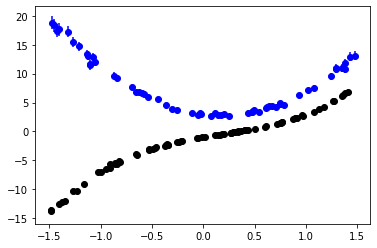

In [29]:
f = lambda x: 2*x**3 -1*x**2 +3*x -1
f_pr = lambda x: 6*x**2 -2*x +3

sig = 0.03
sig_pr = 0.06
n_obs = 80
n_pr_obs = 60

x_obs = np.random.uniform(-1.5,1.5,n_obs)
x_pr_obs = np.random.uniform(-1.5,1.5,n_pr_obs)
#x_obs = np.linspace(-1.5,1.5,n_obs)
eps = np.random.normal(0.,sig,n_obs)
eps_pr = np.random.normal(0.,sig_pr,n_pr_obs)

y_obs = f(x_obs)*(1+eps)
dy_obs = f(x_obs)*sig

y_pr_obs = f_pr(x_pr_obs)*(1+eps_pr)
dy_pr_obs = f_pr(x_pr_obs)*sig_pr



plt.errorbar(x_obs,y_obs,yerr=dy_obs,fmt='ko')
plt.errorbar(x_pr_obs,y_pr_obs,yerr=dy_pr_obs,fmt='bo')

In [36]:
Activation = torch.nn.SiLU()    #torch.nn.SELU(),#torch.nn.GELU(),#torch.nn.Tanh(),
    
model = torch.nn.Sequential(
    torch.nn.Linear(1, 10),
    Activation,
    torch.nn.Linear(10,10),
    Activation,
    torch.nn.Linear(10,5),
    Activation,
    torch.nn.Linear(5,1),
    torch.nn.Flatten(0, 1)
)


def der_act(x):
    t1 = 1 + torch.exp(-x) + x*torch.exp(-x)
    t2 = (1 + torch.exp(-x)).pow(2)
    return t1/t2

def loss_fn_alone(y_pred,data):
    y = torch.from_numpy(data[:,1]).float()
    err_y = torch.from_numpy(data[:,2]).float()
    
    return ((y_pred - y)/err_y).pow(2).sum()


def loss_fn_deri(y_pred,y_pred_pr,data,data_pr):
    y = torch.from_numpy(data[:,1]).float()
    err_y = torch.from_numpy(data[:,2]).float()

    y_pr = torch.from_numpy(data_pr[:,1]).float()
    err_y_pr = torch.from_numpy(data_pr[:,2]).float()

    t1 = ((y_pred - y)/err_y).pow(2).sum()
    t2 = ((y_pred_pr - y_pr)/err_y_pr).pow(2).sum()
    
    return t1 + t2
    

In [37]:
data = np.c_[x_obs,y_obs,dy_obs]
data_pr = np.c_[x_pr_obs,y_pr_obs,dy_pr_obs]

x = torch.from_numpy(data[:,0]).float()
x = torch.reshape(x,(len(data[:,0]),1))

x_pr = torch.from_numpy(data_pr[:,0]).float()
x_pr = torch.reshape(x_pr,(len(data_pr[:,0]),1))


learning_rate = 1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
for t in range(50001):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)
    y_pred_pr = der.der_fun(model,x_pr,der_act,4)

    # Compute and print loss.
    loss = loss_fn_deri(y_pred,y_pred_pr, data,data_pr)
    #loss = loss_fn_alone(y_pred, data)
    if t % 5000 == 0:
        print(t, loss.item())

    optimizer.zero_grad()

    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 1090453.125
5000 243870.3125
10000 243198.75
15000 242728.25
20000 242302.5
25000 241735.6875
30000 240839.6875
35000 240405.8125
40000 240270.28125
45000 240219.75
50000 240191.703125


<ErrorbarContainer object of 3 artists>

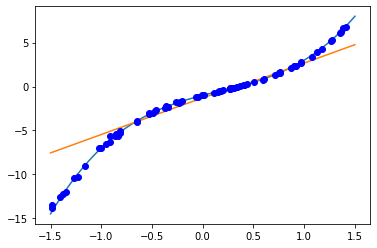

In [38]:
x_test = torch.linspace(-1.5, 1.5, 2000, device=device, dtype=dtype)
x_test = torch.reshape(x_test,(2000,1))

y_th = f(x_test)
y_test = model(x_test)

plt.plot(x_test,y_th)
plt.plot(x_test.detach().numpy().reshape(-1,),y_test.detach().numpy())
plt.errorbar(data[:,0],data[:,1],yerr=data[:,2],fmt="bo")

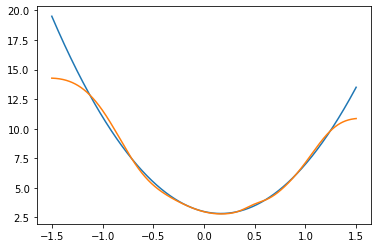

In [34]:
deriv = der.der_fun(model,x_test,der_act,3)
der_the = f_pr(x_test)

plt.plot(x_test,der_the)
plt.plot(x_test,deriv[:,0].detach().numpy())

In [ ]:
plt.plot(x,3e5/deriv[:,0].detach().numpy())